# Requirement of NLTK

In [13]:
!pip install nltk

In [14]:
import nltk
nltk.download('all')
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from collections import defaultdict
from typing import List, Tuple

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

# SVD2 and main

## SVD2 class and preprocessing

### Docs for the context matrices, fit, and cluster descriptors

#### Function build_context_matrices

This function takes in the tokens, vocab_size, and word_to_id variables as inputs. Firstly it computes the word counts of all the tokens using `np.bincount(tokens)` which basically counts the number of occurances of each token in tokens

For example: If

tokens = [1, 2, 3, 4, 4, 1, 3]

vocab size = 4

word_counts = [2, 1, 2, 2] (1 occurs twice, 2 once, 3 twice and 4 occurs twice)

Then based on the value of `w1`, we sort the word_counts and take the ids of the top `w1` frequencies.

`np.argsort(word_counts)[-self.w1:]`

The above function sorts and returns the ids of the top w1 words.

Afterwards, the function initializes two context matrices left and right (L,R) where the matrices are used to represent the relations between the current word with its previous and next word

The 2D array is of size (vocab_size, w1)

Which means how much each word in the vocabulary is related to the top w1 other words in the vocabulary.

Next we iterate through every token and if the current word is related to the previous or the next word i.e, the previous or the next word exists in the `top_words` we increment that entry in the matrix by 1. We do this for every word id in tokens (Keep in mind that the word ids in the tokens array have a range between `0` and `vocab_size` inclusive.)

```
for i in range(len(tokens)-1):
            curr_word = tokens[i]
            # Right context
            next_word = tokens[i+1]
            if next_word in top_words:
                R[curr_word, np.where(top_words == next_word)[0][0]] += 1

            # Left context
            if i > 0:
                prev_word = tokens[i-1]
                if prev_word in top_words:
                    L[curr_word, np.where(top_words == prev_word)[0][0]] += 1

```

`np.where(top_words == prev_word)[0][0]]` This gives the index in `top_words` where the left or right word matches with the top_word.

Return L and R matrix



---

#### Function svd_transform

Here we are computing the SVD of the L and R matrices by using np.linalg.svd. SVD is needed to get the relationship between the words in a reduced dimensionality space.

U: It captures the relationship between words (rows of the matrix) and the latent dimensions (reduced features). Context of the data.

Σ: Scales these relationships by their importance (singular values).

V: It captures the features of the data.

We care about the word level embeddings in this implementation for which we only require U @ E and not V transpose

We reduce the rank of the matrix by considering only the top r1 singular values.

In short,

Perform SVD: Extract the most important latent features of the data.

Reduce Dimensionality: Retain only the top rank dimensions, filtering out noise or less significant dimensions.

Normalize: Prepare the data for tasks like clustering, classification, or similarity computations.

#### **Function** fit

This function trains the model by performing svd and clustering twice
Initially it computes the left and right context matrices, performs svd on both to reduce the rank and only keep important parts of the data.
Uses `hstack` to horizontally stack both the transformed left and right context matrix and then performs k means clustering on the reduced rank descriptors.
These cluster assignments are then used again for the same procedure but this time in the left and right matrices, the cluster descriptors are used for the increments instead of the word individual indices to get more refined clustering.
The final clusters are then returned.

---

#### Function cluster descriptors and kmeans

np.argsort(word_counts): Sorts the word_counts array in ascending order and returns the indices that would sort the array.

    Ex: If word_counts = [3, 1, 4, 1, 5], np.argsort(word_counts) returns [1, 3, 0, 2, 4]

[-n_clusters:]: Selects the indices of the n_clusters most frequent words.

    Ex: If n_clusters = 2, [-n_clusters:] would select the last 2 indices from the sorted array, i.e., [0, 2]

descriptors[top_indices]: This selects the descriptors corresponding to the most frequent words as the initial centroids.

---
np.linalg.norm(init_centroids, axis=1): compute the L2 norm (magnitude) of each centroid vector along the rows.

    Ex: If init_centroids = [[1, 2], [3, 4]], np.linalg.norm(init_centroids, axis=1) -> [2.236, 5.0]

[:, np.newaxis]: reshape norm array to be a column vector.

    Ex: [2.236, 5.0] -> [[2.236], [5.0]]

init_centroids / above two things: normalises each centroid vector to unit length, so that they lie on the unit sphere

    Ex: [[1, 2], [3, 4]] / [[2.236], [5.0]] -> [[0.447, 0.894], [0.6, 0.8]]
---
n_points <- number of datapoints/descriptors

labels is an empty array to store cluster labels

---
np.dot(descriptors, centroids.T): dot product between each descriptor and each centroid. Since the both are normalised, the dot product is equivalent to the cosine similarity.

    Ex: If descriptors = [[1, 2], [3, 4]] and centroids = [[0.447, 0.894], [0.6, 0.8]], it would compute the similarity matrix.

np.argmax(similarities, axis=1): For each descriptor, finds the index of the centroid with the highest similarity (closest in cosine distance), assigning it to that cluster.

    Ex: If similarities = [[0.9, 0.8], [0.7, 0.9]], np.argmax(similarities, axis=1) would return [0, 1].

---
mask = (labels == i): Creates a boolean mask where True indicates that the descriptor belongs to cluster i.

    Ex: If labels = [0, 1, 0, 1] and i = 0, mask -> [True, False, True, False].

weights = word_counts[mask]: Extracts the word counts for the descriptors in the current cluster.

    Ex: If word_counts = [3, 1, 4, 1] and mask = [True, False, True, False], weights -> [3, 4].

weighted_sum = np.sum(descriptors[mask] * weights[:, np.newaxis], axis=0): Computes the weighted sum of the descriptors in the cluster, where the weight is the word frequency.

    Ex: If descriptors[mask] = [[1, 2], [3, 4]] and weights = [3, 4], weighted_sum would be [15, 22].

centroids[i] = weighted_sum / np.sum(weights): Updates the centroid as the weighted average of the descriptors.

    Ex: If weighted_sum = [15, 22] and np.sum(weights) = 7, centroids[i] would be [2.14, 3.14].

centroids[i] = centroids[i] / np.linalg.norm(centroids[i]): Normalizes the new centroid to unit length.

### Code for tagger

In [15]:
class SVD2Tagger:
    def __init__(self, w1=1000, r1=100, k1=500, r2=300, k2=45):
        self.w1 = w1
        self.r1 = r1
        self.k1 = k1
        self.r2 = r2
        self.k2 = k2

    def build_context_matrices(self, tokens, vocab_size, word_to_id):
        word_counts = np.bincount(tokens)
        # print("After using bincount on tokens:")
        # print(word_counts[:100])
        top_words = np.argsort(word_counts)[-self.w1:]

        L = np.zeros((vocab_size, self.w1))
        R = np.zeros((vocab_size, self.w1))

        for i in range(len(tokens)-1):
            curr_word = tokens[i]
            # Right context
            next_word = tokens[i+1]
            if next_word in top_words:
                R[curr_word, np.where(top_words == next_word)[0][0]] += 1

            # Left context
            if i > 0:
                prev_word = tokens[i-1]
                if prev_word in top_words:
                    L[curr_word, np.where(top_words == prev_word)[0][0]] += 1

        return L, R

    def svd_transform(self, matrix, rank):
        # rank reduction
        U, S, Vt = np.linalg.svd(matrix, full_matrices=False)
        S = np.diag(S[:rank])
        U = U[:, :rank]
        return normalize(U @ S)

    # def cluster_descriptors(self, descriptors, n_clusters, word_counts):
    #     top_indices = np.argsort(word_counts)[-n_clusters:]
    #     init_centroids = descriptors[top_indices]

    #     kmeans = KMeans(n_clusters=n_clusters, init=init_centroids, n_init=1)

    #     # init centroids removed so that multiple n_init are possible
    #     # kmeans = KMeans(n_clusters=n_clusters, n_init=1)
    #     return kmeans.fit_predict(descriptors)

    def cluster_descriptors(self, descriptors, n_clusters, word_counts):
      top_indices = np.argsort(word_counts)[-n_clusters:]
      init_centroids = descriptors[top_indices]

      # normalise to unit len
      init_centroids = init_centroids / np.linalg.norm(init_centroids, axis=1)[:, np.newaxis]

      n_points = descriptors.shape[0]
      labels = np.zeros(n_points, dtype=int)
      centroids = init_centroids.copy()

      max_iters = 100
      for _ in range(max_iters):
          old_labels = labels.copy()

          similarities = np.dot(descriptors, centroids.T)  # dot product for cosine similarity
          labels = np.argmax(similarities, axis=1)

          if np.all(old_labels == labels): #convergence check
              break

          for i in range(n_clusters):
              mask = (labels == i)
              if np.any(mask):
                  # weighted average using word frequencies
                  weights = word_counts[mask]
                  weighted_sum = np.sum(descriptors[mask] * weights[:, np.newaxis], axis=0)
                  centroids[i] = weighted_sum / np.sum(weights)

                  # normalise again (?)
                  centroids[i] = centroids[i] / np.linalg.norm(centroids[i])

      return labels

    def fit(self, tokens, vocab_size, word_to_id):
        # pass 1
        print("Building initial context matrices.")
        L1, R1 = self.build_context_matrices(tokens, vocab_size, word_to_id)

        print("Performing first SVD transformation.")
        L1_transformed = self.svd_transform(L1, self.r1)
        R1_transformed = self.svd_transform(R1, self.r1)

        descriptors1 = np.hstack([L1_transformed, R1_transformed])

        print("Performing first clustering.")
        word_counts = np.bincount(tokens)
        first_clusters = self.cluster_descriptors(descriptors1, self.k1, word_counts)

        # pass 2
        print("Building refined context matrices.")
        L2 = np.zeros((vocab_size, self.k1))
        R2 = np.zeros((vocab_size, self.k1))

        for i in range(len(tokens)-1):
            curr_word = tokens[i]
            # right context
            next_word = tokens[i+1]
            R2[curr_word, first_clusters[next_word]] += 1

            # left context
            if i > 0:
                prev_word = tokens[i-1]
                L2[curr_word, first_clusters[prev_word]] += 1

        print("Performing second SVD transformation.")
        L2_transformed = self.svd_transform(L2, self.r2)
        R2_transformed = self.svd_transform(R2, self.r2)

        # second clustering
        print("Performing final clustering.")
        descriptors2 = np.hstack([L2_transformed, R2_transformed])
        self.final_clusters = self.cluster_descriptors(descriptors2, self.k2, word_counts)

        return self.final_clusters

    def get_cluster_examples(self, tokens, word_to_id, n_examples=5):
        id_to_word = {v: k for k, v in word_to_id.items()}
        cluster_examples = defaultdict(list)

        for word_id in range(len(self.final_clusters)):
            cluster = self.final_clusters[word_id]
            if word_id in id_to_word:
                word = id_to_word[word_id]
                cluster_examples[cluster].append(word)

        # debug print n top examples per cluster
        for cluster in sorted(cluster_examples.keys()):
            examples = cluster_examples[cluster][:n_examples]
            print(f"Cluster {cluster}: {', '.join(examples)}")



---



### Docs for the dataset and its preprocessing


#### Function prepare_treebank_data

In this function we are passing a list of sentences represented as a 2D matrix of size 2 tuples where the first element in the tuple is the word for the sentence and the second element is the pos tag for that word in the nltk pentreebank corpus.

Initially in the function, we are converting all the words to lowercase and then in the variable `word_freq` we are storing the frequency of all the words in `words`. Thereafter, we are including only those words in the `word_to_id` hashmap whose frequency is greater than 1. Also the after adding all the words with frequency greater than 1 in the hashmap, we add `<UNK>` key to the hashmap to denote all the words which we ignored initially (Words with frequency = 1). The id corresponding to the key is just the length of the hashmap (`len(word_to_id)`) at that point in time.

In the final steps, the function computes the `tokens` array where it runs through all the words again and then checks if the current word exists in the `word_to_id` mapping. If the word exists, then the corresponding id stored in the `word_to_id` mapping gets appended to the `tokens` array otherwise the id of `<UNK>` gets appended which is
`len(word_to_id) - 1`.

Example
Function Argument: [[("I", ), ("like", ), ("to", ), ("eat", ), ("bananas", )], [("I", ), ("like", ), ("to", ), ("eat", ), ("apples", )]]

The above input shows two sentences with one word difference.

`freq`: I - 2

  like - 2

  to - 2

  eat - 2

  bananas - 1

  apples - 1

`word_to_id` - I - 0

like - 1

to - 2

eat - 3


bananas and apples wont come in the dictionary because their frequency is = 1.

Last two words are <"UNK">s  for this example.

tokens = [0, 1, 2, 3, 4, 4]

len(word_to_id) = 4


What each return value represents
tokens: Id value for every word in the corpus.

word_to_id - Unique words which have a frequency > 1.

vocab_size - Number of unique word ids that we are dealing with i.e, `len(word_to_id)`.


#### Documentation for the M-1 mapping method:

params: true_tags -> a list of the true labels, predicted_clusters -> a list of the predicted clusters for each token.

cluster_to_tag: The outer defaultdict creates a dictionary for each cluster label, the inner defaultdict(int) initializes counts to zero for each tag within a cluster, this structure will store the count of each true tag within each predicted cluster.

Next, we pair each predicter cluster label with its corresponding true tag, then we iterate over these pairs to build a frequency table of tags for each cluster.

In order to assign each cluster to its most frequent tag we first initialize an empty dict 'cluster_tag_mapping' then iterate over every clsuter to find the tag with the highest count and assign it to majority_tag.
cluster_to_tag[cluster].items() returns a view of tag-count pairs for the cluster
max(..., key=lambda x: x[1]) finds the pair with the highest count
x represents a tuple (tag, count), and x[1] is the count
[0] extracts the tag from the (tag, count) pair.
Assigns the majority tag to majority_tag.

for calculation, we initialize a counter correct to keep track of the number of correct assignments, then determine the total number of tags to consider in the accuracy calculation.
accuracy = correct/ total

Example:

Suppose we have:
true_tags = ['NOUN', 'VERB', 'NOUN', 'ADJ', 'VERB']
predicted_clusters = [1, 2, 1, 3, 2]
Cluster to Tag Counts:
Cluster 1:
'NOUN': 2
Cluster 2:
'VERB': 2
Cluster 3:
'ADJ': 1
Majority Tags:
Cluster 1: 'NOUN'
Cluster 2: 'VERB'
Cluster 3: 'ADJ'
Correct Assignments:
Token 1: Cluster 1 mapped to 'NOUN' vs. true 'NOUN' → Correct
Token 2: Cluster 2 mapped to 'VERB' vs. true 'VERB' → Correct
Token 3: Cluster 1 mapped to 'NOUN' vs. true 'NOUN' → Correct
Token 4: Cluster 3 mapped to 'ADJ' vs. true 'ADJ' → Correct
Token 5: Cluster 2 mapped to 'VERB' vs. true 'VERB' → Correct
Accuracy:
Correct = 5, Total = 5, Accuracy = 1.0

#### Docs for 1-1 mapping method:


The parameters are the same as the last method.

We start by getting the unique tags and clusters, by creating a sorted list of unique true tags by converting true_tags to a set and sorting it and similarly creating a sorted list of unique predicted clusters.

Initialize a confusion matrix of zeros with dimensions:
Rows correspond to unique predicted clusters.
Columns correspond to unique true tags.
The matrix will be used to count the occurrences of each cluster-tag pair.

Populate confusion matrix:
Iterate over pairs of predicted clusters and true tags, find the index of the current cluster in unique_clusters, Find the index of the current tag in unique_tags
Increments the count in the confusion matrix at position [cluster_idx][tag_idx]: confusion_matrix[cluster_idx][tag_idx] += 1
This process counts how many times each cluster is associated with each true tag.

Hungarian algo:
Calls linear_sum_assignment from scipy.optimize on the negated confusion matrix: linear_sum_assignment(-confusion_matrix)
The algorithm finds the assignment that minimizes the total cost. Negating the confusion matrix turns the maximization problem into a minimization one.
Retrieves two arrays: row_ind: Indices of the selected rows (clusters), col_ind: Indices of the assigned columns (tags).


Constructs a dictionary cluster_tag_mapping:
Uses a dictionary comprehension.
Iterates over pairs of indices i, j from row_ind and col_ind, Map each cluster (unique_clusters[i]) to a tag (unique_tags[j]), Ensures each cluster is mapped to one unique tag, and vice versa

for calculation, Iterate over each pair of predicted cluster (pred) and true tag (true).
Checks whether: The predicted cluster pred exists in cluster_tag_mapping, the tag assigned to the cluster (cluster_tag_mapping[pred]) matches the true tag true.If both conditions are met, increments correct by one.
This counts the number of tokens where the predicted cluster is correctly mapped to the true tag.

accuracy = correct/total



xample Scenario:

Suppose we have:

true_tags = ['NOUN', 'VERB', 'ADJ', 'NOUN', 'VERB']
predicted_clusters = [2, 1, 3, 2, 1]
Steps:

Unique Tags and Clusters:

unique_tags = ['ADJ', 'NOUN', 'VERB']
unique_clusters = [1, 2, 3]

confusion_matrix =
[[0, 0, 2],  # Cluster 1 with 'VERB' (counts)
 [0, 2, 0],  # Cluster 2 with 'NOUN'
 [1, 0, 0]]  # Cluster 3 with 'ADJ'
Applying Hungarian Algorithm:

Optimal assignment might be:
Cluster 1 → 'VERB'
Cluster 2 → 'NOUN'
Cluster 3 → 'ADJ'
Cluster-to-Tag Mapping:

{1: 'VERB', 2: 'NOUN', 3: 'ADJ'}
Accuracy Calculation:

Correct assignments:
Token 1: Cluster 2 mapped to 'NOUN' vs. true 'NOUN' → Correct
Token 2: Cluster 1 mapped to 'VERB' vs. true 'VERB' → Correct
Token 3: Cluster 3 mapped to 'ADJ' vs. true 'ADJ' → Correct
Token 4: Cluster 2 mapped to 'NOUN' vs. true 'NOUN' → Correct
Token 5: Cluster 1 mapped to 'VERB' vs. true 'VERB' → Correct
Accuracy: 5 / 5 = 1.0

#### docs for VI score calculation

Uses Counter from the collections module to count the occurrences of each predicted label in pred_tags. The result is stored in p_pred, which maps each predicted label to its count.
Similarly, counts the occurrences of each true label in true_tags and stores the result in p_true.

Next, we creates pairs of (predicted label, true label) using zip(pred_tags, true_tags) and counts their occurrences with Counter. The result p_joint maps each pair to its count.

Variation of Information Calculation:
A comment indicating the start of the VI computation.
Initializes vi to zero. This variable will accumulate the VI score.
Begins a loop over all unique pairs (i, j) in p_joint, where i is a predicted label and j is a true label.
Calculates the joint probability p_ij of the pair (i, j) by dividing its count by the total number of data points N.
Calculates the marginal probability p_i of the predicted label i by dividing its count by N.
Calculates the marginal probability p_j of the true label j by dividing its count by N.
Checks if p_ij is greater than zero to ensure the logarithm is defined.
Updates the VI score vi by adding the contribution of the pair (i, j):
The term p_ij * (np.log2(p_ij) - np.log2(p_i) - np.log2(p_j)) calculates the mutual information component for this pair.


Explanations:

Computes the Variation of Information (VI) score, which measures the difference between two clusterings (labelings) of the same dataset.
VI is based on information theory and quantifies how much information is lost or gained when transitioning from one clustering to another.
Key Concepts:

Marginal Probabilities (p_i, p_j): The probabilities of individual predicted and true labels occurring.
Joint Probabilities (p_ij): The probabilities of predicted and true labels occurring together.
Mutual Information: Represents the amount of shared information between the predicted and true labels.
Entropy: Measures the uncertainty associated with a random variable.
Mathematical Background:


Step-by-Step Computation:

Compute Counts:
Counts of predicted labels (p_pred), true labels (p_true), and joint counts (p_joint).
By dividing counts by N, we get marginal (p_i, p_j) and joint probabilities (p_ij).
For each pair (i, j), if p_ij is greater than zero:
Calculate the term ( p_{ij} \left( \log_2 p_{ij} - \log_2 p_i - \log_2 p_j \right) ).
Accumulate this value into vi.
The condition if p_ij > 0 ensures we do not compute the logarithm of zero, which is undefined.
The base 2 logarithm (np.log2) is used to measure information in bits, which is standard in information theory.

Interpretation:

The VI score quantifies the difference between the predicted labels and the true labels.
A higher VI value indicates greater dissimilarity.
In this example, a VI score of 1.0 suggests a moderate level of difference between the clusterings.

### Code for dataset and evaluation

In [17]:
from typing import List, Dict, Tuple

def prepare_treebank_data(tagged_sents: List[List[Tuple[str, str]]]) -> Tuple[np.ndarray, Dict, int]:

    word_to_id = {}
    words = [word.lower() for sent in tagged_sents for word, _ in sent]

    word_freq = defaultdict(int)
    for word in words:
        word_freq[word] += 1

    for word in word_freq:
        if word_freq[word] > 1:  # only include words that appear more than once
            word_to_id[word] = len(word_to_id)

    word_to_id['<UNK>'] = len(word_to_id)

    # id mapping
    tokens = []
    for sent in tagged_sents:
        for word, _ in sent:
            word = word.lower()
            if word in word_to_id:
                tokens.append(word_to_id[word])
            else:
                tokens.append(word_to_id['<UNK>'])

    return np.array(tokens), word_to_id, len(word_to_id)

def calculate_M1_score(true_tags, predicted_clusters):
# Each cluster is mapped to its most common true tag

    # mapping
    cluster_to_tag = defaultdict(lambda: defaultdict(int))

    # count tag occurrences for each cluster
    for cluster, tag in zip(predicted_clusters, true_tags):
        cluster_to_tag[cluster][tag] += 1

    # A cluster -> most freq tag
    cluster_tag_mapping = {}
    for cluster in cluster_to_tag:
        majority_tag = max(cluster_to_tag[cluster].items(), key=lambda x: x[1])[0]
        cluster_tag_mapping[cluster] = majority_tag

    correct = 0
    total = len(true_tags)

    for pred, true in zip(predicted_clusters, true_tags):
        if pred in cluster_tag_mapping and cluster_tag_mapping[pred] == true:
            correct += 1

    return correct / total

def calculate_1to1_score(true_tags, predicted_clusters):
    # Each cluster can only be mapped to one true tag

    unique_tags = sorted(set(true_tags))
    unique_clusters = sorted(set(predicted_clusters))

    confusion_matrix = np.zeros((len(unique_clusters), len(unique_tags)))

    for cluster, tag in zip(predicted_clusters, true_tags):
        cluster_idx = unique_clusters.index(cluster)
        tag_idx = unique_tags.index(tag)
        confusion_matrix[cluster_idx][tag_idx] += 1

    # hungarian algo
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix)


    cluster_tag_mapping = {unique_clusters[i]: unique_tags[j]
                          for i, j in zip(row_ind, col_ind)}

    correct = 0
    total = len(true_tags)

    for pred, true in zip(predicted_clusters, true_tags):
        if pred in cluster_tag_mapping and cluster_tag_mapping[pred] == true:
            correct += 1

    return correct / total

from collections import defaultdict, Counter

def calculate_vi_score(true_tags, pred_tags):
    # Variation of Information score
    N = len(true_tags)

    # marginal probabilities
    p_pred = Counter(pred_tags)
    p_true = Counter(true_tags)

    # for joint probability
    p_joint = Counter(zip(pred_tags, true_tags))

    vi = 0
    for i, j in p_joint:
        p_ij = p_joint[(i, j)] / N
        p_i = p_pred[i] / N
        p_j = p_true[j] / N
        if p_ij > 0:
            vi += p_ij * (np.log2(p_ij) - np.log2(p_i) - np.log2(p_j))

    return vi

def evaluate_clusters(tagger, test_sents, true_tags):
    from sklearn.metrics import adjusted_rand_score

    test_clusters = []
    true_pos_tags = []

    for sent, true_sent in zip(test_sents, true_tags):
        for word, true_tag in zip(sent, true_sent):
            word = word.lower()
            if word in tagger.word_to_id:
                word_id = tagger.word_to_id[word]
                if word_id < len(tagger.final_clusters):  # Add check for valid word_id
                    test_clusters.append(tagger.final_clusters[word_id])
                    true_pos_tags.append(true_tag)

    if not test_clusters:
        print("Warning: No valid clusters found for evaluation")
        return {
            'ari': 0.0,
            'many_to_one': 0.0,
            'one_to_one': 0.0,
            'vi_score': 0.0
        }

    ari = adjusted_rand_score(true_pos_tags, test_clusters)
    m1_score = calculate_M1_score(true_pos_tags, test_clusters)
    one_to_one_score = calculate_1to1_score(true_pos_tags, test_clusters)
    vi_score = calculate_vi_score(true_pos_tags, test_clusters)

    # Get cluster distribution for each POS tag
    tag_cluster_dist = defaultdict(lambda: defaultdict(int))
    for tag, cluster in zip(true_pos_tags, test_clusters):
        tag_cluster_dist[tag][cluster] += 1

    # # Print detailed distribution
    # print("\nCluster Distribution for each POS tag:")
    # for tag in sorted(tag_cluster_dist.keys()):
    #     clusters = tag_cluster_dist[tag]
    #     total = sum(clusters.values())
    #     main_clusters = sorted(clusters.items(), key=lambda x: x[1], reverse=True)[:3]
    #     print(f"\n{tag}:")
    #     for cluster, count in main_clusters:
    #         print(f"  Cluster-{cluster}: {count/total*100:.1f}%")

    return {
        'ari': ari,
        'many_to_one': m1_score,
        'one_to_one': one_to_one_score,
        'vi_score': vi_score

    }



---



## Main

In [18]:
def main():
    print("Loading Penn Treebank data...")
    corpus = nltk.corpus.treebank.tagged_sents()

    train_size = int(len(corpus) * 0.8)
    train_data = corpus[:train_size]
    test_data = corpus[train_size:]

    print("Preparing data...")
    tokens, word_to_id, vocab_size = prepare_treebank_data(train_data)

    print("Training SVD2Tagger...")

    # best case once upon a time
    # tagger = SVD2Tagger(w1=1000, r1=300, k1=500, r2=300, k2=46)

    # tagger = SVD2Tagger(w1=1200, r1=100, k1=300, r2=200, k2=46)

    # default as in the paper
    tagger = SVD2Tagger(w1=1000, r1=100, k1=500, r2=300, k2=46)
    clusters = tagger.fit(tokens, vocab_size, word_to_id)

    # Save word_to_id mapping in tagger
    tagger.word_to_id = word_to_id
    tagger.id_to_word = {v: k for k, v in word_to_id.items()}

    # print("\nCluster Examples:")
    # tagger.get_cluster_examples(tokens, word_to_id)

    test_words = [[word.lower() for word, _ in sent] for sent in test_data]
    test_tags = [[tag for _, tag in sent] for sent in test_data]

    # evaluation
    print("\nEvaluating clusters...")
    metrics = evaluate_clusters(tagger, test_words, test_tags)
    print(f"VI score: {metrics['vi_score']:.4f}")
    print(f"Adjusted Rand Index: {metrics['ari']:.4f}")
    print(f"Many-to-One (M:1) Accuracy: {metrics['many_to_one']:.4f}")
    print(f"One-to-One (1:1) Accuracy: {metrics['one_to_one']:.4f}")

    # Example tagging
    # print("\nExample Tagging:")
    # example_sent = "banana banana banana banana apple".lower().split()
    # word_ids = [word_to_id.get(word, word_to_id['<UNK>']) for word in example_sent]
    # valid_word_ids = [wid for wid in word_ids if wid < len(tagger.final_clusters)]
    # clusters = [tagger.final_clusters[wid] for wid in valid_word_ids]

    # for word, cluster in zip(example_sent[:len(clusters)], clusters):
    #     print(f"{word}: Cluster-{cluster}")

if __name__ == "__main__":
    main()

Loading Penn Treebank data...
Preparing data...
Training SVD2Tagger...
Building initial context matrices.
Performing first SVD transformation.
Performing first clustering.
Building refined context matrices.
Performing second SVD transformation.
Performing final clustering.

Evaluating clusters...
VI score: 2.8570
Adjusted Rand Index: 0.3359
Many-to-One (M:1) Accuracy: 0.6574
One-to-One (1:1) Accuracy: 0.4477


## Train/Test split removed

In [ ]:
def main():
    print("Loading Penn Treebank data...")
    corpus = nltk.corpus.treebank.tagged_sents()

    print("Preparing data...")
    tokens, word_to_id, vocab_size = prepare_treebank_data(corpus)

    print("Training SVD2Tagger...")

    # best case once upon a time
    tagger = SVD2Tagger(w1=1000, r1=300, k1=500, r2=300, k2=46)

    # default as in the paper
    # tagger = SVD2Tagger(w1=1000, r1=100, k1=500, r2=300, k2=46)
    clusters = tagger.fit(tokens, vocab_size, word_to_id)

    tagger.word_to_id = word_to_id
    tagger.id_to_word = {v: k for k, v in word_to_id.items()}

    # print("\nCluster Examples:")
    # tagger.get_cluster_examples(tokens, word_to_id)

    test_words = [[word.lower() for word, _ in sent] for sent in corpus]
    test_tags = [[tag for _, tag in sent] for sent in corpus]

    print("\nEvaluating clusters...")
    metrics = evaluate_clusters(tagger, test_words, test_tags)
    print(f"VI score: {metrics['vi_score']:.4f}")
    print(f"Adjusted Rand Index: {metrics['ari']:.4f}")
    print(f"Many-to-One (M:1) Accuracy: {metrics['many_to_one']:.4f}")
    print(f"One-to-One (1:1) Accuracy: {metrics['one_to_one']:.4f}")

    # Example tagging
    # print("\nExample Tagging:")
    # example_sent = "banana banana banana banana apple".lower().split()
    # word_ids = [word_to_id.get(word, word_to_id['<UNK>']) for word in example_sent]
    # valid_word_ids = [wid for wid in word_ids if wid < len(tagger.final_clusters)]
    # clusters = [tagger.final_clusters[wid] for wid in valid_word_ids]

    # for word, cluster in zip(example_sent[:len(clusters)], clusters):
    #     print(f"{word}: Cluster-{cluster}")

if __name__ == "__main__":
    main()

Loading Penn Treebank data...
Preparing data...
Training SVD2Tagger...
Building initial context matrices...
Performing first SVD transformation...
Performing first clustering...
Building refined context matrices...
Performing second SVD transformation...
Performing final clustering...

Evaluating clusters...
VI score: 2.7805
Adjusted Rand Index: 0.3174
Many-to-One (M:1) Accuracy: 0.6290
One-to-One (1:1) Accuracy: 0.4427


## Varying parameters values (tuning).

3 values for 4, 5 parameters = 3^ (4,5) distinct runs

### Trying out a few different values and calculating geometric mean of accuracy

In [ ]:
import statistics as stats
import matplotlib.pyplot as plt

# default
w1_values = [800, 1000, 1200]
r1_values = [50, 100, 200]
k1_values = [300, 500, 700]
r2_values = [200, 300, 400]
k2_values = [46]

# w1_values = [500, 1000, 1500]
# r1_values = [100, 200, 300]
# k1_values = [200, 500, 800]
# r2_values = [100, 200, 300]
# k2_values = [20, 30, 40]

best_accuracy = 0
best_params = None
geomean_values = []
param_labels = []

print("Loading Penn Treebank data")
corpus = nltk.corpus.treebank.tagged_sents()

train_size = int(len(corpus) * 0.8)
train_data = corpus[:train_size]
test_data = corpus[train_size:]

# Prepare data
print("Preparing data...")
tokens, word_to_id, vocab_size = prepare_treebank_data(train_data)

test_words = [[word.lower() for word, _ in sent] for sent in test_data]
test_tags = [[tag for _, tag in sent] for sent in test_data]

for w1 in w1_values:
    for r1 in r1_values:
        for k1 in k1_values:
            for r2 in r2_values:
                for k2 in k2_values:
                    print(f"Parameters: w1={w1}, r1={r1}, k1={k1}, r2={r2}, k2={k2}")

                    tagger = SVD2Tagger(w1=w1, r1=r1, k1=k1, r2=r2, k2=k2)
                    clusters = tagger.fit(tokens, vocab_size, word_to_id)
                    tagger.word_to_id = word_to_id
                    tagger.id_to_word = {v: k for k, v in word_to_id.items()}

                    metrics = evaluate_clusters(tagger, test_words, test_tags)
                    geomean = stats.geometric_mean((metrics['many_to_one'], metrics['one_to_one']))

                    geomean_values.append(geomean)
                    param_labels.append(f"w1={w1}, r1={r1}, k1={k1}, r2={r2}, k2={k2}")

                    if geomean > best_accuracy:
                        best_accuracy = geomean
                        best_params = (w1, r1, k1, r2, k2)

                    print()

print(f"Best accuracy: {best_accuracy:.4f}")
print(f"Best parameters: w1={best_params[0]}, r1={best_params[1]}, k1={best_params[2]}, r2={best_params[3]}, k2={best_params[4]}")

Loading Penn Treebank data...
Preparing data...
Parameters: w1=800, r1=50, k1=300, r2=200, k2=46
Building initial context matrices...
Performing first SVD transformation...
Performing first clustering...
Building refined context matrices...
Performing second SVD transformation...
Performing final clustering...

Parameters: w1=800, r1=50, k1=300, r2=300, k2=46
Building initial context matrices...
Performing first SVD transformation...
Performing first clustering...
Building refined context matrices...
Performing second SVD transformation...
Performing final clustering...

Parameters: w1=800, r1=50, k1=300, r2=400, k2=46
Building initial context matrices...
Performing first SVD transformation...
Performing first clustering...
Building refined context matrices...
Performing second SVD transformation...
Performing final clustering...

Parameters: w1=800, r1=50, k1=500, r2=200, k2=46
Building initial context matrices...
Performing first SVD transformation...
Performing first clustering...
B

### Plotting the geometric mean of (all) two accuracy metrics

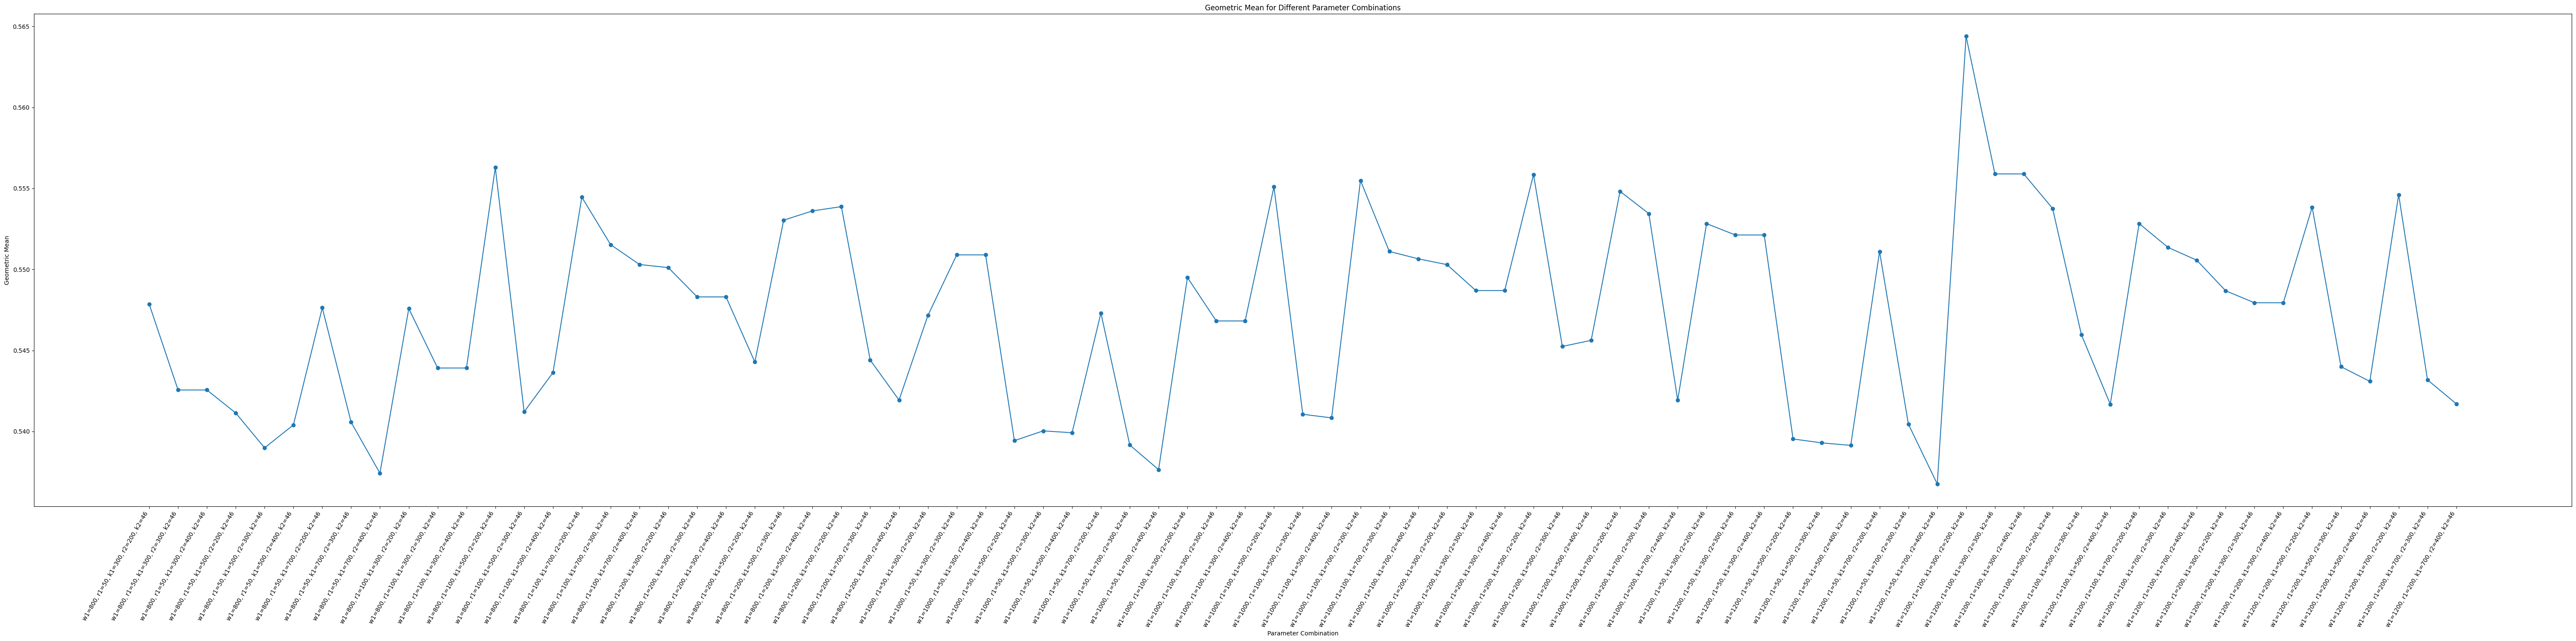

In [ ]:
# import matplotlib.pyplot as plt
plt.figure(figsize=(60, 15))
plt.plot(geomean_values, marker='o')
plt.xticks(range(len(geomean_values)), param_labels, rotation=60, ha='right')
plt.xlabel('Parameter Combination')
plt.ylabel('Geometric Mean')
plt.title('Geometric Mean for Different Parameter Combinations')
plt.tight_layout()
plt.show()

### Plotting the geometric mean of the two accuracy metrics > 0.55

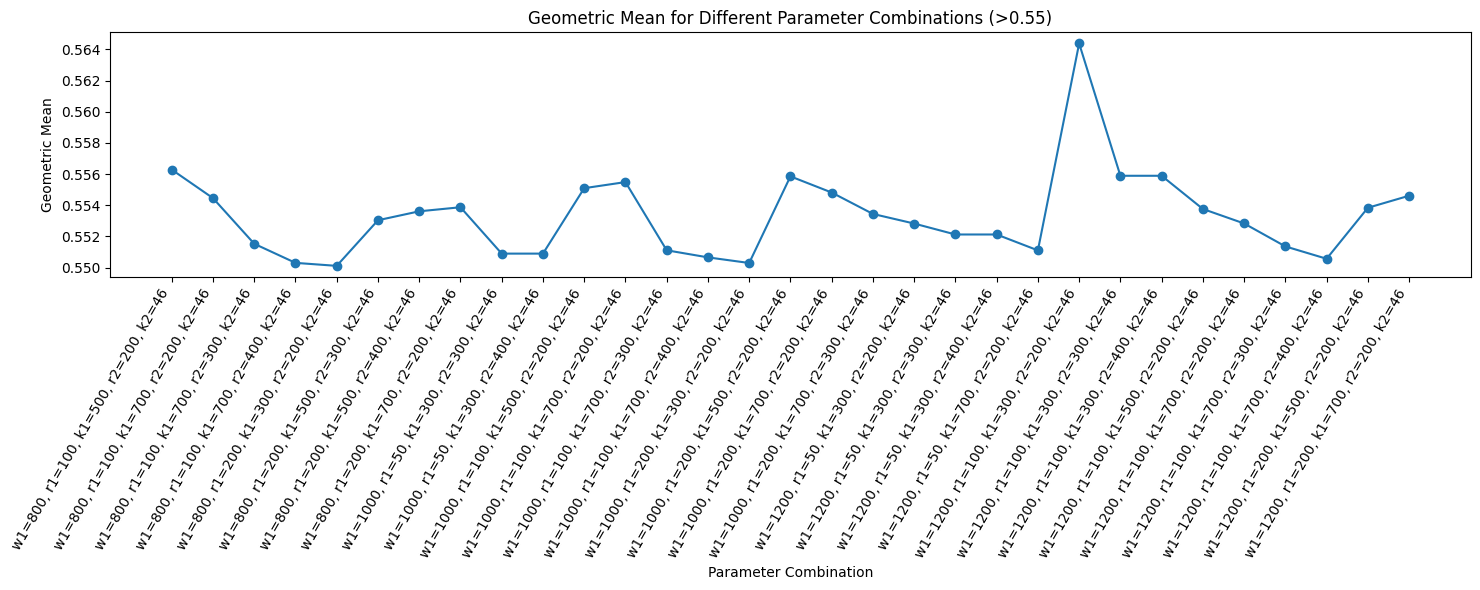

In [ ]:
plt.figure(figsize=(15, 6))

filtered_data = [(geomean, label) for geomean, label in zip(geomean_values, param_labels) if geomean > 0.55]
filtered_geomeans, filtered_labels = zip(*filtered_data)

plt.plot(filtered_geomeans, marker='o')
plt.xticks(range(len(filtered_geomeans)), filtered_labels, rotation=60, ha='right')
plt.xlabel('Parameter Combination')
plt.ylabel('Geometric Mean')
plt.title('Geometric Mean for Different Parameter Combinations (>0.55)')
plt.tight_layout()
plt.show()

## Unique tags

In [7]:
def find_unique_tags(tagged_sents: List[List[Tuple[str, str]]]) -> int:
  # tuple is word, tag | list outside it is a sentence | last list is a collection of strings
    tags = [tag for sent in tagged_sents for _, tag in sent]
    unique_tags = set(tags)
    print(unique_tags)
    return len(unique_tags)

def count_sentences_and_words(tagged_sents: List[List[Tuple[str, str]]]) -> Tuple[int, int]:
    sentence_count = len(tagged_sents)
    word_count = sum(len(sent) for sent in tagged_sents)
    return sentence_count, word_count

corpus = nltk.corpus.treebank.tagged_sents()
unique_tag_count = find_unique_tags(corpus)
print(f"Number of unique tags: {unique_tag_count}")

sentence_count, word_count = count_sentences_and_words(corpus)
print(f"Number of sentences: {sentence_count}")
print(f"Total word + punctuation count: {word_count}")

{'IN', 'EX', 'RB', 'CD', '#', 'VBD', 'CC', 'WP', 'FW', '$', 'WP$', 'VBG', 'VB', 'DT', 'RBS', 'JJS', 'TO', 'MD', 'NNP', 'NNPS', 'WRB', '-RRB-', 'PRP$', 'RP', ':', 'SYM', 'VBP', 'PRP', 'POS', 'LS', '-NONE-', 'RBR', '-LRB-', 'VBN', 'PDT', 'JJR', '.', '``', 'JJ', ',', 'NN', 'UH', 'VBZ', 'WDT', "''", 'NNS'}
Number of unique tags: 46
Number of sentences: 3914
Total word + punctuation count: 100676


## .

In [12]:
import numpy as np
from collections import defaultdict, Counter
from scipy.optimize import linear_sum_assignment
from nltk.tag.hmm import HiddenMarkovModelTrainer
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def calc_m_to_1(pred_tags, true_tags):
    tag_map = defaultdict(lambda: defaultdict(int))
    for p, t in zip(pred_tags, true_tags):
        tag_map[p][t] += 1

    correct = 0
    for pred_tag in tag_map:
        max_count = max(tag_map[pred_tag].values())
        correct += max_count
    return correct / len(true_tags)

def calc_1_to_1(pred_tags, true_tags):
    unique_pred = list(set(pred_tags))
    unique_true = list(set(true_tags))
    matrix = np.zeros((len(unique_pred), len(unique_true)))

    for i, p in enumerate(unique_pred):
        for j, t in enumerate(unique_true):
            count = sum(1 for x, y in zip(pred_tags, true_tags) if x == p and y == t)
            matrix[i][j] = count

    row_ind, col_ind = linear_sum_assignment(-matrix)
    correct = sum(matrix[i][j] for i, j in zip(row_ind, col_ind))
    return correct / len(true_tags)

def calc_vi(pred_tags, true_tags):
    N = len(true_tags)
    p_pred = Counter(pred_tags)
    p_true = Counter(true_tags)
    p_joint = Counter(zip(pred_tags, true_tags))

    vi = 0
    for i, j in p_joint:
        p_ij = p_joint[(i, j)] / N
        p_i = p_pred[i] / N
        p_j = p_true[j] / N
        if p_ij > 0:
            vi += p_ij * (np.log2(p_ij) - np.log2(p_i) - np.log2(p_j))
    return vi

def evaluate_unsupervised_hmm(tokens, word_to_id, vocab_size, test_tags):
    n_states = 46
    states = [f'state_{i}' for i in range(n_states)]

    id_to_word = {v: k for k, v in word_to_id.items()}
    words = [[id_to_word[t] for t in tokens]]

    logger.info("Training Unsupervised HMM...")
    trainer = HiddenMarkovModelTrainer()

    model = trainer.train_unsupervised(
        words,
        states=states,
        symbols=list(word_to_id.keys())
    )

    tagged_sent = model.tag([id_to_word[t] for t in tokens])
    predictions = [tag for _, tag in tagged_sent]

    m_to_1_accuracy = calc_m_to_1(predictions, test_tags)
    one_to_one_accuracy = calc_1_to_1(predictions, test_tags)
    vi_score = calc_vi(predictions, test_tags)
    n_tags = len(set(predictions))

    logger.info(f"M-to-1 Accuracy: {m_to_1_accuracy:.4f}")
    logger.info(f"1-to-1 Accuracy: {one_to_one_accuracy:.4f}")
    logger.info(f"VI Score: {vi_score:.4f}")
    logger.info(f"Number of unique states: {n_tags}")

    return {
        'm_to_1_accuracy': m_to_1_accuracy,
        'one_to_one_accuracy': one_to_one_accuracy,
        'vi_score': vi_score,
        'n_tags': n_tags,
        'predictions': predictions
    }

if __name__ == "__main__":
    try:
        corpus = nltk.corpus.treebank.tagged_sents()

        train_size = int(len(corpus) * 0.8)
        train_data = corpus[:train_size]
        test_data = corpus[train_size:]

        tokens, word_to_id, vocab_size = prepare_treebank_data(train_data)

        test_words = [[word.lower() for word, _ in sent] for sent in test_data]
        test_tags = [[tag for _, tag in sent] for sent in test_data]

        metrics = evaluate_unsupervised_hmm(tokens, word_to_id, vocab_size, test_tags)
        print("HMM evaluation completed successfully")
    except Exception as e:
        print(f"Failed to evaluate HMM: {str(e)}")

Failed to evaluate HMM: A probability distribution must have at least one sample.
